<h1 class="header"><img class="logo" src="../images/socib_logo.png" width="200px"></h1>

<h3> STYLING NOTEBOOK (OPTIONAL)</h3>

In [1]:
from IPython.core.display import HTML
import urllib
HTML(urllib.urlopen('https://raw.githubusercontent.com/socib/API_examples/master/style/custom/custom.css').read())

<h3> HANDY PYTHON PACKAGES </h3>

In [2]:
import requests
import json
from IPython.display import display, HTML, JSON
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import shapely
from shapely.geometry import box
from matplotlib import colors
from json2html import *
%matplotlib inline

<h3> PREREQUISITES </h3>

In [3]:
api_key = '' #write you SOCIB api_key
api_url = 'http://api.socib.es'
headers = {
    'accept': 'application/vnd.socib+json',
    'apikey': api_key,
}

As already shown in ['Searching for certain data-sources'](searching_for_certain_data_sources.ipynb), there are parameters that added to an endpoint allows applying some filtering over the generic answer: let's have a look to the ones available for the <b>/data-sources/{id}/data</b> auxiliary endpoint and apply them to a deployment.

<h3> REQUESTING A DATA-SOURCE'S DATA <span>WITH PARAMS</span></h3>

<h3>1. FIND A DATA-SOURCE</h3>

Setting a certain time range, a defined area, a certain platform type and a certain variable to find a number of matching deployments:

In [4]:
time_range_start = '2017-07-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
time_range_end =  '2018-12-01T00:00:00' # should match the notation YYYY-MM-DDTHH:MM:SS
platform_type = 'Research Vessel'
variables = 'sea_water_temperature'

In [5]:
min_lat = 40.0#float
max_lat = 38.0 #float
min_lon = 0.0 #float
max_lon = 3.0#float
bbox = str(min_lat)+','+str(max_lat)+','+str(min_lon)+','+str(max_lon)

In [6]:
end_point = '/data-sources/'
url_addons = '?platform_type=%s&initial_datetime=%s&end_datetime=%s&standard_variable=%s&bbox=%s'%(platform_type,time_range_start,time_range_end, variables,bbox)
request = requests.get('%s%s%s' % (api_url, end_point,url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point,url_addons))
print(" ")
print('A total of %s SOCIB deployments match the above searching criteria'% (response['count']))

Requested url: http://api.socib.es/data-sources/?platform_type=Research Vessel&initial_datetime=2017-07-01T00:00:00&end_datetime=2018-12-01T00:00:00&standard_variable=sea_water_temperature&bbox=40.0,38.0,0.0,3.0
 
A total of 15 SOCIB deployments match the above searching criteria


Let's have a look to the metadata of one of the above deployments:

In [7]:
targeted_deployment = response['results'][2]#i.e deployment/data-source number 2 of the above page
metadata = {k:v for k, v in targeted_deployment.items() if k != 'entries'} #skipping the deployment data for later
HTML(json2html.convert(json=metadata))

<h3>2. REQUEST ITS DATA</h3>

Let's choose only one of the above variables by means of <b>/data-sources/{id}/data/ </b> auxiliary endpoint:

In [40]:
variable = 'sea_water_temperature'

In [41]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/?standard_variable='+variable
request = requests.get('%s%s' % (api_url, end_point_plus_aux), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s' % (api_url, end_point_plus_aux))

Requested url: http://api.socib.es/data-sources/02f2600d3c/data/?standard_variable=sea_water_temperature


In [42]:
def get_data_overview(response):
    #provides a quick glimse of a data-source variables overlooking its data values
    variable_metadata = {} 
    for level in response.keys():
        variable_metadata[level] = {}
        for item in response[level]['feature_types']:
            variable_metadata[level][item['feature_type']] = {}
            for standard_name in item['variables'].keys():
                variable_metadata[level][item['feature_type']][standard_name] = {}
                for var in item['variables'][standard_name].keys():
                    variable_metadata[level][item['feature_type']][standard_name][var] = {}
                    for key,value in item['variables'][standard_name][var].items():
                        if key != 'data':#overlooking data values
                            variable_metadata[level][item['feature_type']][standard_name][var][key] = value
    return variable_metadata

In [43]:
display(HTML(json2html.convert(json=get_data_overview(response))))

<h3>3. PLOT ITS DATA</h3>

Let's have an quick overview of the params and coordinates associated to the selected variable: 

In [20]:
def get_matching_params(param, response):
    #returns matching params
    params = [] 
    for level in response.keys():
        for item in response[level]['feature_types']:
            for standard_name in item['variables'].keys():
                for var in item['variables'][standard_name].keys():
                    if var == param:
                        try:
                            params.append({'units':item['variables'][standard_name][var]['units'], 'data': item['variables'][standard_name][var]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type'], 'name': param})
                        except:
                            params.append({'units': '-', 'data': item['variables'][standard_name][var]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type'], 'name': param})
    return params

In [21]:
def get_matching_coords(coord,response):
    #returns matching coords
    coords = [] 
    for level in response.keys():
        for item in response[level]['feature_types']:
            for standard_name in item['coordinates'].keys():
                if standard_name == coord:
                    try:
                        coords.append({'units':item['coordinates'][standard_name]['units'], 'data': item['coordinates'][standard_name]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type']})
                    except:
                        coords.append({'units': '-', 'data': item['coordinates'][standard_name]['data'], 'level': level, 'standard_name': standard_name, 'feature': item['feature_type']})
    return coords

In [22]:
params = get_matching_params('WTR_TEM_01', response)
display(HTML(json2html.convert(json=[{k:v for k,v in param.items() if k!= 'data'} for param in params])))

units,feature,standard_name,name,level
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1_corr
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L0
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1


In [23]:
latitudes = get_matching_coords('latitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lat.items() if k!= 'data'} for lat in latitudes])))

units,standard_name,feature,level
degrees_north,latitude,trajectoryProfileIrregular,L1_corr
degrees_north,latitude,trajectoryProfileIrregular,L0
degrees_north,latitude,trajectoryProfileIrregular,L1


In [24]:
longitudes = get_matching_coords('longitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in longitudes])))

units,standard_name,feature,level
degrees_east,longitude,trajectoryProfileIrregular,L1_corr
degrees_east,longitude,trajectoryProfileIrregular,L0
degrees_east,longitude,trajectoryProfileIrregular,L1


In [25]:
times = get_matching_coords('time', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in times])))

units,standard_name,feature,level
-,time,trajectoryProfileIrregular,L1_corr
-,time,trajectoryProfileIrregular,L0
-,time,trajectoryProfileIrregular,L1


In [26]:
depths = get_matching_coords('depth', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in depths])))

units,standard_name,feature,level
m,depth,trajectoryProfileIrregular,L1_corr
m,depth,trajectoryProfileIrregular,L0
m,depth,trajectoryProfileIrregular,L1


Choosing the first matching param on the list:

In [27]:
var_values = np.array(params[0]['data'],dtype=float)
lat_values = np.array(latitudes[0]['data'],dtype=float)
lon_values = np.array(longitudes[0]['data'],dtype=float)
depth_values = np.array(depths[0]['data'],dtype=float)
time_values = np.array(times[0]['data'])

In [28]:
var_units = params[0]['units']
var_std_name = params[0]['standard_name']
var_name = params[0]['name']

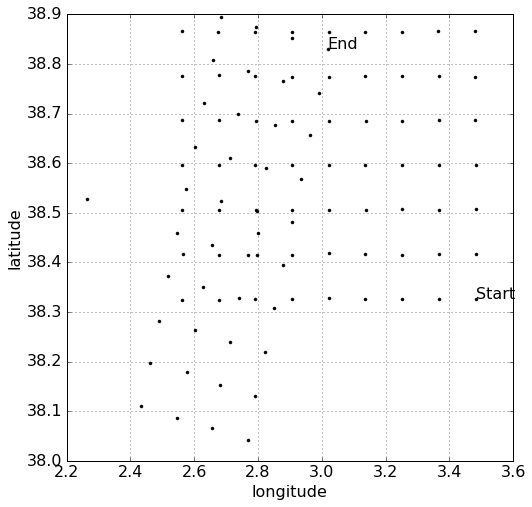

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon_values, lat_values, 'ko', ms=3)
plt.text(lon_values[0], lat_values[0], 'Start', fontsize=16)
plt.text(lon_values[-1], lat_values[-1], 'End', fontsize=16)

plt.grid()
plt.ylabel('latitude', fontsize=16)
plt.xlabel('longitude', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

In [30]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var_values[0]), vmax=max(var_values[0]))

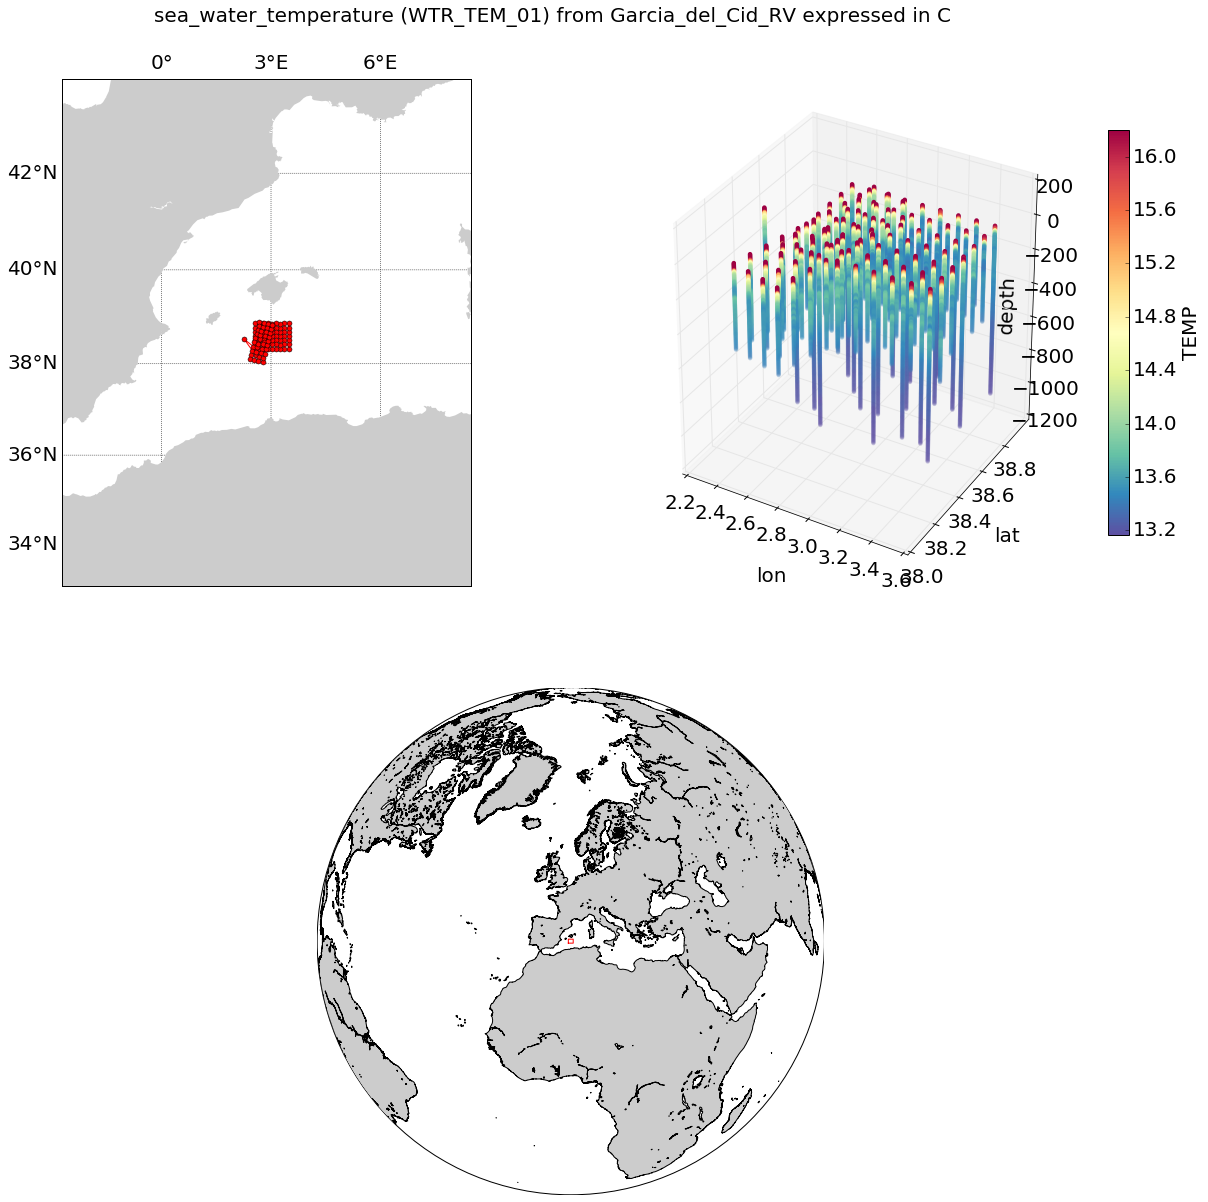

In [31]:
fig = plt.figure(figsize=(20,20))

#top right figure
ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time_values)-1):
    plt.scatter(lon_values[a]*np.ones(len(depth_values[0])),lat_values[a]*np.ones(len(depth_values[0])), zs=-depth_values[a,:], zdir='z', s=20, c=var_values[a], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

#top left figure
ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat_values)-5, urcrnrlat=max(lat_values)+5,llcrnrlon=min(lon_values)-5, urcrnrlon=max(lon_values)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon_values, lat_values)
m.plot(x,y, 'ro-', ms=5)

#bottom figure
ax = fig.add_subplot(212)
bounding_box = shapely.geometry.box(lonmin, latmin, lonmax, latmax)
x = bounding_box.centroid.x
y = bounding_box.centroid.y
map = Basemap(projection='ortho',lat_0=y, lon_0=x,resolution='i')
map.drawmapboundary()
map.fillcontinents()
map.drawcoastlines()
xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
ys = [latmin,latmin,latmax,latmax,latmin]
map.plot(xs, ys,latlon = True, color='red')

plt.suptitle(var_std_name +' ('+var_name+') from '+metadata['platform']['name']+' expressed in '+var_units, fontsize=20, y=0.95)

plt.show()

<h3>3. SUBSET ITS DATA</h3>

The next query parameters are available for subsetting the above generic answer of the <b>/data-sources/{id}/data/</b> endpoint:

<ul><li><h3>REQUESTING A DATA-SOURCE'S DATA BY <span>TIME-RANGE</span></h3></li></ul>

From the step number 1 we know the whole time range covered by the deployment:

In [48]:
end_point = '/data-sources/'+targeted_deployment['id']
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s. Be aware of the id.' % (api_url, end_point))

Requested url: http://api.socib.es/data-sources/02f2600d3c. Be aware of the id.


In [49]:
requested_range = {k:v for k, v in response.items() if k == 'initial_datetime' or k == 'end_datetime'}
HTML(json2html.convert(json=requested_range))

initial_datetime,2018-05-06T02:16:39Z
end_datetime,2018-05-16T15:24:19Z


 Let's keep only the first day of data:

In [46]:
targeted_initial_datetime = targeted_deployment['initial_datetime'].split('T')[0]+'T00:00:00'
targeted_end_datetime = targeted_deployment['initial_datetime'].split('T')[0]+'T23:59:59'
print('targeted_initial_datetime: '+ targeted_deployment['initial_datetime'])
print('targeted_end_datetime: '+ targeted_deployment['end_datetime'])

targeted_initial_datetime: 2018-05-06T02:16:39Z
targeted_end_datetime: 2018-05-16T15:24:19Z


In [50]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable=sea_water_temperature&initial_datetime=%s&end_datetime=%s'%(targeted_initial_datetime,targeted_end_datetime)
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux, url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/02f2600d3c/data/?standard_variable=sea_water_temperature&initial_datetime=2018-05-06T00:00:00&end_datetime=2018-05-06T23:59:59


In [51]:
display(HTML(json2html.convert(json=get_data_overview(response))))

Let's have a look to the resulting subset:

In [53]:
params = get_matching_params('WTR_TEM_01', response)
display(HTML(json2html.convert(json=[{k:v for k,v in param.items() if k!= 'data'} for param in params])))

units,feature,standard_name,name,level
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1_corr
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L0
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1


In [54]:
latitudes = get_matching_coords('latitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lat.items() if k!= 'data'} for lat in latitudes])))

units,standard_name,feature,level
degrees_north,latitude,trajectoryProfileIrregular,L1_corr
degrees_north,latitude,trajectoryProfileIrregular,L0
degrees_north,latitude,trajectoryProfileIrregular,L1


In [55]:
longitudes = get_matching_coords('longitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in longitudes])))

units,standard_name,feature,level
degrees_east,longitude,trajectoryProfileIrregular,L1_corr
degrees_east,longitude,trajectoryProfileIrregular,L0
degrees_east,longitude,trajectoryProfileIrregular,L1


In [56]:
times = get_matching_coords('time', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in times])))

units,standard_name,feature,level
-,time,trajectoryProfileIrregular,L1_corr
-,time,trajectoryProfileIrregular,L0
-,time,trajectoryProfileIrregular,L1


In [57]:
depths = get_matching_coords('depth', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in depths])))

units,standard_name,feature,level
m,depth,trajectoryProfileIrregular,L1_corr
m,depth,trajectoryProfileIrregular,L0
m,depth,trajectoryProfileIrregular,L1


Choosing the first matching param on the list:

In [58]:
var_values = np.array(params[0]['data'],dtype=float)
lat_values = np.array(latitudes[0]['data'],dtype=float)
lon_values = np.array(longitudes[0]['data'],dtype=float)
depth_values = np.array(depths[0]['data'],dtype=float)
time_values = np.array(times[0]['data'])

In [59]:
var_units = params[0]['units']
var_std_name = params[0]['standard_name']
var_name = params[0]['name']

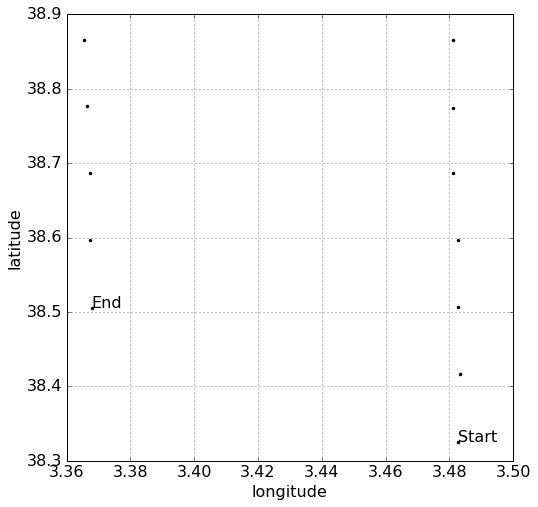

In [60]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon_values, lat_values, 'ko', ms=3)
plt.text(lon_values[0], lat_values[0], 'Start', fontsize=16)
plt.text(lon_values[-1], lat_values[-1], 'End', fontsize=16)

plt.grid()
plt.ylabel('latitude', fontsize=16)
plt.xlabel('longitude', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

In [61]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var_values[0]), vmax=max(var_values[0]))

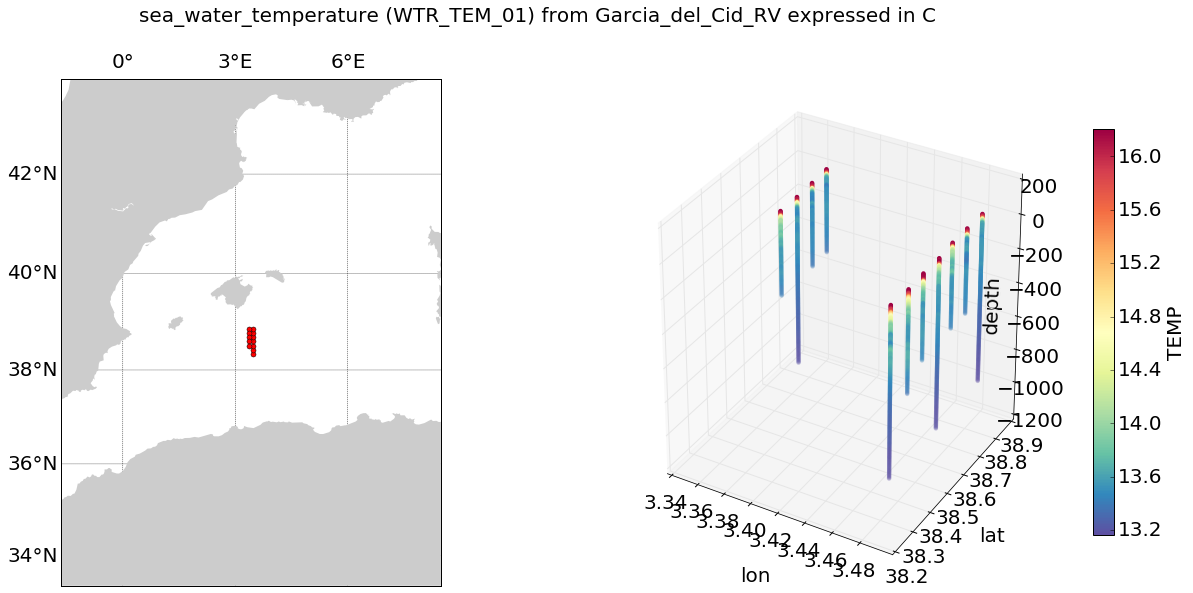

In [62]:
fig = plt.figure(figsize=(20,20))

#top right figure
ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time_values)-1):
    plt.scatter(lon_values[a]*np.ones(len(depth_values[0])),lat_values[a]*np.ones(len(depth_values[0])), zs=-depth_values[a,:], zdir='z', s=20, c=var_values[a], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

#top left figure
ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat_values)-5, urcrnrlat=max(lat_values)+5,llcrnrlon=min(lon_values)-5, urcrnrlon=max(lon_values)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon_values, lat_values)
m.plot(x,y, 'ro-', ms=5)

plt.suptitle(var_std_name +' ('+var_name+') from '+metadata['platform']['name']+' expressed in '+var_units, fontsize=20, y=0.95)

plt.show()

<ul><li><h3>REQUESTING A DATA-SOURCE'S DATA BY <span>BOUNDING-BOX</span></h3></li></ul>

From the step number 1 we know the whole area covered by the deployment:

In [63]:
end_point = '/data-sources/'+targeted_deployment['id']
request = requests.get('%s%s' % (api_url, end_point), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s. Be aware of the id.' % (api_url, end_point))

Requested url: http://api.socib.es/data-sources/02f2600d3c. Be aware of the id.


In [64]:
coverage_metadata = {k:v for k, v in response.items() if k == 'coverage_bounding_box'}
HTML(json2html.convert(json=coverage_metadata))

Let's think we are interested in the data recovered in one of the corners of the total area covered by the deployment:

In [76]:
min_lat = 38.3#float
max_lat = 38.9 #float
min_lon = 3.0 #float
max_lon = 3.6#float
bbox = str(min_lat)+','+str(max_lat)+','+str(min_lon)+','+str(max_lon)

In [77]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable=sea_water_temperature&bbox=%s'%(bbox)
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux, url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/02f2600d3c/data/?standard_variable=sea_water_temperature&bbox=38.3,38.9,3.0,3.6


In [78]:
display(HTML(json2html.convert(json=get_data_overview(response))))

Let's have a look to the subset:

In [79]:
params = get_matching_params('WTR_TEM_01', response)
display(HTML(json2html.convert(json=[{k:v for k,v in param.items() if k!= 'data'} for param in params])))

units,feature,standard_name,name,level
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1_corr
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L0
C,trajectoryProfileIrregular,sea_water_temperature,WTR_TEM_01,L1


In [80]:
latitudes = get_matching_coords('latitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lat.items() if k!= 'data'} for lat in latitudes])))

units,standard_name,feature,level
degrees_north,latitude,trajectoryProfileIrregular,L1_corr
degrees_north,latitude,trajectoryProfileIrregular,L0
degrees_north,latitude,trajectoryProfileIrregular,L1


In [81]:
longitudes = get_matching_coords('longitude', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in longitudes])))

units,standard_name,feature,level
degrees_east,longitude,trajectoryProfileIrregular,L1_corr
degrees_east,longitude,trajectoryProfileIrregular,L0
degrees_east,longitude,trajectoryProfileIrregular,L1


In [82]:
times = get_matching_coords('time', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in times])))

units,standard_name,feature,level
-,time,trajectoryProfileIrregular,L1_corr
-,time,trajectoryProfileIrregular,L0
-,time,trajectoryProfileIrregular,L1


In [83]:
depths = get_matching_coords('depth', response)
display(HTML(json2html.convert(json=[{k:v for k,v in lon.items() if k!= 'data'} for lon in depths])))

units,standard_name,feature,level
m,depth,trajectoryProfileIrregular,L1_corr
m,depth,trajectoryProfileIrregular,L0
m,depth,trajectoryProfileIrregular,L1


Choosing the first matching param on the list:

In [84]:
var_values = np.array(params[0]['data'],dtype=float)
lat_values = np.array(latitudes[0]['data'],dtype=float)
lon_values = np.array(longitudes[0]['data'],dtype=float)
depth_values = np.array(depths[0]['data'],dtype=float)
time_values = np.array(times[0]['data'])

In [85]:
var_units = params[0]['units']
var_std_name = params[0]['standard_name']
var_name = params[0]['name']

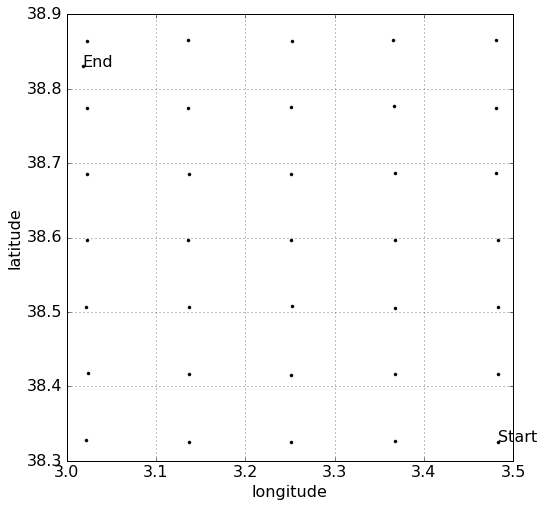

In [86]:
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
plt.plot(lon_values, lat_values, 'ko', ms=3)
plt.text(lon_values[0], lat_values[0], 'Start', fontsize=16)
plt.text(lon_values[-1], lat_values[-1], 'End', fontsize=16)

plt.grid()
plt.ylabel('latitude', fontsize=16)
plt.xlabel('longitude', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.show()

In [87]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var_values[0]), vmax=max(var_values[0]))

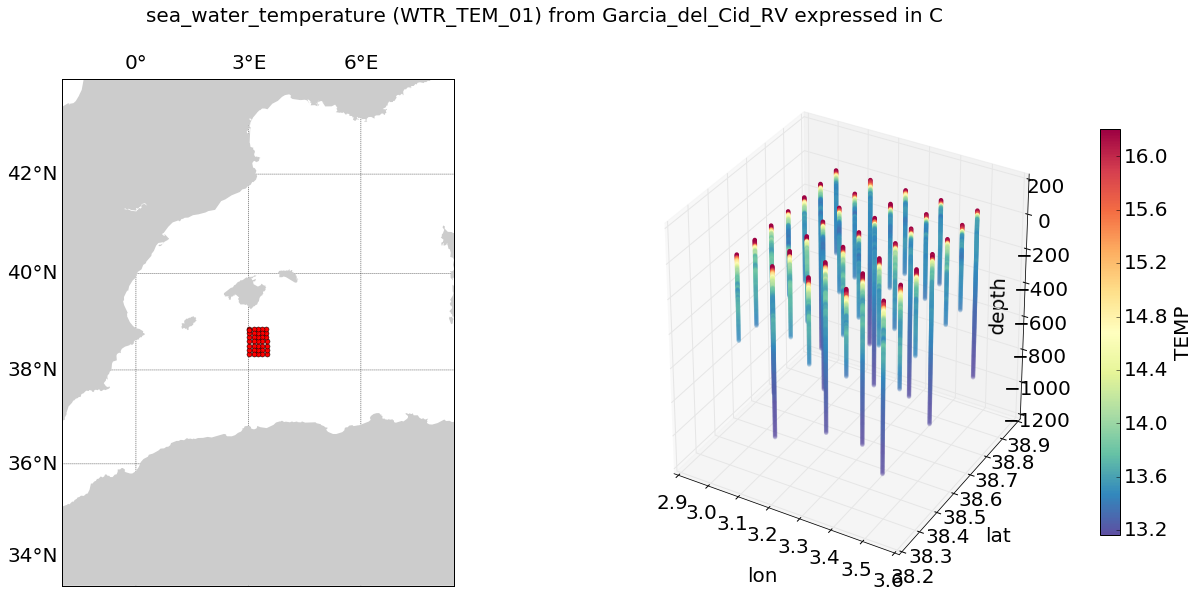

In [88]:
fig = plt.figure(figsize=(20,20))

#top right figure
ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time_values)-1):
    plt.scatter(lon_values[a]*np.ones(len(depth_values[0])),lat_values[a]*np.ones(len(depth_values[0])), zs=-depth_values[a,:], zdir='z', s=20, c=var_values[a], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

#top left figure
ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat_values)-5, urcrnrlat=max(lat_values)+5,llcrnrlon=min(lon_values)-5, urcrnrlon=max(lon_values)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon_values, lat_values)
m.plot(x,y, 'ro-', ms=5)

plt.suptitle(var_std_name +' ('+var_name+') from '+metadata['platform']['name']+' expressed in '+var_units, fontsize=20, y=0.95)

plt.show()

<ul><li><h3>REQUESTING A DATA-SOURCE'S DATA BY <span>ELEVATION-RANGE</span></h3></li></ul>

In [89]:
min_elevation = -100.0
max_elevation = 0
elevation = str(min_elevation)+','+str(max_elevation)

In [90]:
end_point_plus_aux = '/data-sources/'+targeted_deployment['id']+'/data/'
url_addons = '?standard_variable=sea_water_temperature&elevation_range=%s'%(elevation)
request = requests.get('%s%s%s' % (api_url, end_point_plus_aux, url_addons), headers=headers)
response = json.loads(request.text)
print('Requested url: '+'%s%s%s' % (api_url, end_point_plus_aux, url_addons))

Requested url: http://api.socib.es/data-sources/02f2600d3c/data/?standard_variable=sea_water_temperature&elevation_range=-100.0,0


In [91]:
display(HTML(json2html.convert(json=get_data_overview(response))))

In [93]:
params = get_matching_params('WTR_TEM_01', response)
latitudes = get_matching_coords('latitude', response)
longitudes = get_matching_coords('longitude', response)
times = get_matching_coords('time', response)
depths = get_matching_coords('depth', response)

Choosing the first matching param on the list:

In [94]:
var_values = np.array(params[0]['data'],dtype=float)
lat_values = np.array(latitudes[0]['data'],dtype=float)
lon_values = np.array(longitudes[0]['data'],dtype=float)
depth_values = np.array(depths[0]['data'],dtype=float)
time_values = np.array(times[0]['data'])

In [95]:
var_units = params[0]['units']
var_std_name = params[0]['standard_name']
var_name = params[0]['name']

Let's have a look to the subset:

In [96]:
lonmin, lonmax = ax.get_xlim()
latmin, latmax = ax.get_ylim()
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=min(var_values[0]), vmax=max(var_values[0]))

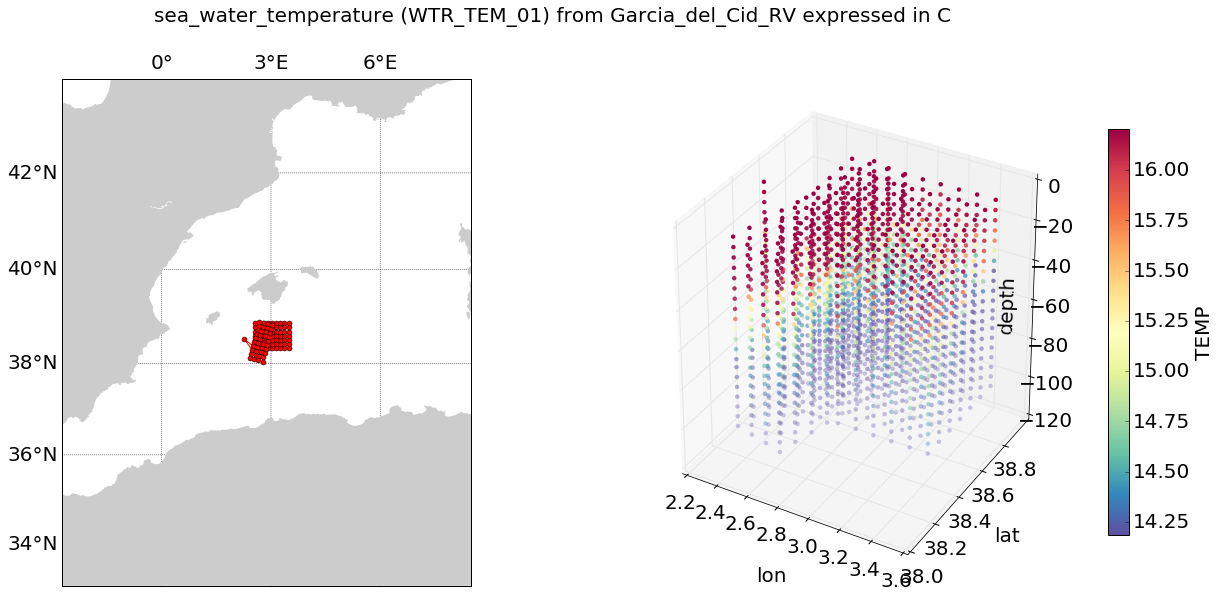

In [97]:
fig = plt.figure(figsize=(20,20))

#top right figure
ax = fig.add_subplot(222, projection='3d')
for a in range(0, len(time_values)-1):
    plt.scatter(lon_values[a]*np.ones(len(depth_values[0])),lat_values[a]*np.ones(len(depth_values[0])), zs=-depth_values[a,:], zdir='z', s=20, c=var_values[a], edgecolor='None', cmap=cmap, norm=norm)
    plt.tick_params(labelsize=20)
cb = plt.colorbar(fraction=0.040, cmap=cmap, norm=norm)
cb.ax.tick_params(labelsize=20) 
cb.set_label(label="TEMP", size=20)
ax.set_zlabel('depth',labelpad=-40,rotation=90,fontsize=20)
ax.set_ylabel('lat',labelpad=20,fontsize=20)
ax.set_xlabel('lon',labelpad=20,fontsize=20)

#top left figure
ax = fig.add_subplot(221)
m = Basemap(projection='merc', llcrnrlat=min(lat_values)-5, urcrnrlat=max(lat_values)+5,llcrnrlon=min(lon_values)-5, urcrnrlon=max(lon_values)+5, lat_ts=38., resolution='i')
m.fillcontinents(zorder=2)
m.drawparallels(np.arange(-90.,91.,2.), labels=[1,0,0,0], linewidth=0.5, zorder=1, fontsize=20)
m.drawmeridians(np.arange(-180.,181.,3.), labels=[0,0,1,0], linewidth=0.5, zorder=1, fontsize=20)
x,y = m(lon_values, lat_values)
m.plot(x,y, 'ro-', ms=5)

plt.suptitle(var_std_name +' ('+var_name+') from '+metadata['platform']['name']+' expressed in '+var_units, fontsize=20, y=0.95)

plt.show()

<h3> WHAT ELSE?</h3>

<ul>
<li><b>RESAMPLING A DATA-SOURCE'S DATA</b> <br><br>If you want to know more about how to resample a given data-source's data overlooking the netCDF format, please have a look at the [Example 5](resampling_a_data_sources_data.ipynb) ('Resampling a data-source's data'), where it is explained how to use query parameters over the API auxiliary endpoints to resample a deployments data.</li>
</ul>